In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Defining Value Class for Neural Network

In [2]:
class Value():
    def __init__(self,data,operation=None,_children =(),label=""):
        self.data = data
        self.grad = 0.0
        self.label = label
        self.operation = operation
        self._backprop = lambda: None
        self.children = set(_children)
        
    def __repr__(self):
        return f"Value:{self.data},label:{self.label}"
        
    def __add__(self,other):
        
        if isinstance(other,(int,float)):
            other = Value(other)
            
        v = Value(self.data+other.data,"+",(self,other))
        # v.label = f"{self.label}{other.label}"
        def backprop():
            self.grad += 1.0*v.grad
            other.grad += 1.0*v.grad
            
        v._backprop = backprop
        return v
    def __sub__(self,other):
        return self+(-1*other)
    
    def __rsub__(self,other):
        return self - other
        
    def __mul__(self,other):
        
        if isinstance(other,(int,float)):
            other = Value(other)
            
        v = Value(self.data*other.data,"*",(self,other))
        # v.label = f"{self.label}{other.label}"
        def backprop():
            self.grad += other.data*v.grad
            other.grad += self.data*v.grad
            
        v._backprop = backprop
        return v
    
    def __pow__(self,other):
        assert isinstance(other,(int,float)),"Only int or float"
        v = Value(self.data**other,"pow",(self,))
        def backprop():
            self.grad += other*(self.data**(other- 1)) * v.grad
        v._backprop = backprop
        return v
    def __rmul__(self,other):  
        return self*other

    def __radd__(self,other):
        return self+other
        
    def __truediv__(self,other):
        if isinstance(other,(int,float)):
            other = Value(other)
        return self * (other.data**-1)
        
    def __rtruediv__(self,other):
        if isinstance(other,(int,float)):
            other = Value(other)
        return ((self.data)**-1) * other 
        
    def tanh(self):
        tanh = (np.exp(2*self.data) - 1)/(np.exp(2*self.data) +1)
        v = Value(tanh,"tanh",(self,))
        
        def backprop():
            self.grad += (1 - (tanh**2)) * v.grad
        
        v._backprop = backprop
        return v
            
    def backprop(self):
        def topological_sort(root,sorted_graph):            
            
            # for x in root.children:
            #     if x not in sorted_graph:
            #         sorted_graph.append(x)
            
            if root not in sorted_graph:
                for x in root.children:
                    topological_sort(x,sorted_graph)
                
                
                sorted_graph.append(root)
            return sorted_graph
        
        topo_list = topological_sort(self,[])
        self.grad = 1
        for x in topo_list[::-1]:
            x._backprop()

### Example operation of forward and backward pass with graph visualization

In [3]:
a = Value(1.0,label="a")
a1 = Value(1.5,label="a1")
b = Value(1.75,label="b")
c = b * a1;c.label = "c";
d = Value(1.25,label="d")
e = a * b;e.label = "e";
f = c + e;f.label = "f";
g = d * f;g.label = "g";
o = g.tanh();o.label = "o"

In [4]:
import graphviz as graph 

In [5]:
def draw_nn(root: Value,dot,visited = []):
    
    uid = str(id(root))
    if uid not in visited:
        visited.append(uid)
        dot.node(uid,label = "{ %s | data %.4f | grad %.4f }" % (root.label, root.data, root.grad), shape='record')
        
        if root.operation != None:
            dot.node(uid+root.operation,label =root.operation)
            dot.edge(uid+root.operation,uid)
        if len(root.children) > 0:
            for x in root.children:
                xuid = str(id(x))
                dot.edge(xuid,uid+root.operation)
                draw_nn(x,dot,visited)
    return dot
    

In [6]:
o.backprop()

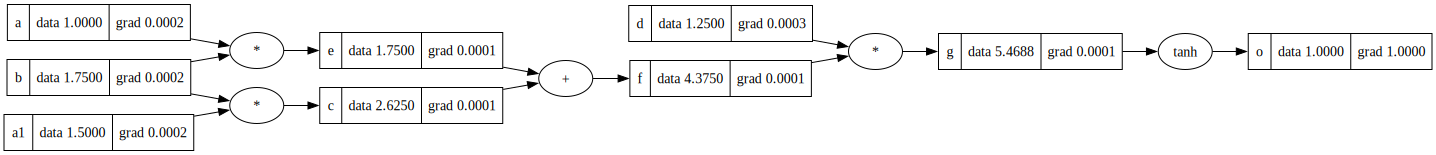

In [7]:
dot = graph.Digraph("nn",graph_attr={'rankdir': 'LR'},node_attr={"orientation":"270"})
draw_nn(o,dot)

### Defining Neuron,Layers and Neural Network classes to build a Multi-layer preceptron

In [84]:
class Neuron:
    def __init__(self,nin,layer = 0,neuron = 1):
        self.W = [Value(x) for x in np.random.normal(size=nin)]
        self.layer = layer
        for x in range(nin):
            self.W[x].label = f"X{neuron}W{self.layer}{x}"
        self.b = Value(np.random.normal(size=1)[0],label=f"bias{self.layer}")

    def __call__(self,X):
        out = sum((w*x for w,x in zip(self.W,X)),self.b)
        out = out.tanh()
        return out

    def parameters(self):
        return (self.W + [self.b])

class Layer:
    def __init__(self,nin,n,layer = 0):
        self.layer = layer
        self.neurons = [Neuron(nin,self.layer) for x in range(n)]
        
    def __call__(self,X):
        layer_out = []
        for i,n in enumerate(self.neurons):
            out = n(X)
            out.label = f"N{self.layer}{i}"
            layer_out.append(out)        

        return layer_out[0] if len(layer_out)==1 else layer_out
        
    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

class NeuralNet:
    def __init__(self,nin,layer_spec : list):
        self.nin = nin
        self.nlayers = layer_spec
        self.layerspec = [nin] + layer_spec
        self.layers=[Layer(self.layerspec[x],self.layerspec[x+1],layer=x) for x in range(len(self.layerspec)-1)]
    def __call__(self,x):
        out = x
        for layer in self.layers:
            out = layer(out)
        return out
        
    def parameters(self):
        return [p for l in self.layers for p in l.parameters()]

    def _loss(self,ytest,ypred):
        return sum((yout - ygt)**2 for ygt, yout in zip(ytest, ypred))

    def _sgd(self):
        for p in nn.parameters():
            p.data += -0.005 * p.grad # learning rate * grad, learning rate the mangnitude of movement required in the slope, - sign to ensure the loss go down always

    def train(self,xtrain,ytrain,iteration = 20):
        for k in range(iteration):
        
            # forward pass
            ypred = [self(x) for x in xtrain]
            loss = self._loss(ytrain, ypred)
            
            # backward pass
            for p in self.parameters():
                p.grad = 0.0
            loss.backprop()
            
            # update
            self._sgd()
        
            print(k, loss.data)

    def test(self,xtest,ytest):
        ypred = [self(x) for x in xtest]
        loss = self._loss(ytest,ypred)
        return ypred,loss
    

### Initializing network and Training

In [85]:
nn = NeuralNet(3, [4, 4, 1])

In [86]:
xs = [
  [2.0, 3.0, -1.0],
  [3.1, -1.1, 0.5],
  [0.6, 1.1, 1.2],
  [1.0, 1.5, -1.6],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [87]:
nn.train(xs,ys,100)

0 0.5735207930742345
1 0.458026826931123
2 0.3797437223757736
3 0.3235167602445985
4 0.28133285315975964
5 0.2485975032330643
6 0.22250266898230361
7 0.2012419798778049
8 0.18360379172002728
9 0.16874664973000802
10 0.15606882268036598
11 0.145129116806059
12 0.13559699047938503
13 0.12722010133022463
14 0.11980259449529491
15 0.11319021503189294
16 0.10725987469249475
17 0.1019121968507007
18 0.09706609579446959
19 0.09265477277428728
20 0.0886227160630449
21 0.08492342389794813
22 0.08151765547540887
23 0.07837207282425081
24 0.07545817556302459
25 0.07275145759456789
26 0.0702307337346375
27 0.06787759771824582
28 0.06567598269153396
29 0.06361180232337169
30 0.0616726558347024
31 0.059847584077075786
32 0.05812686666455913
33 0.05650185233519285
34 0.05496481637402976
35 0.05350884020215732
36 0.052127709221032686
37 0.050815825769262885
38 0.04956813465146857
39 0.04838005917466466
40 0.04724744600555775
41 0.046166517464131585
42 0.045133830111455296
43 0.04414623868548653
44 0.0

### Created Neural Network Diagram

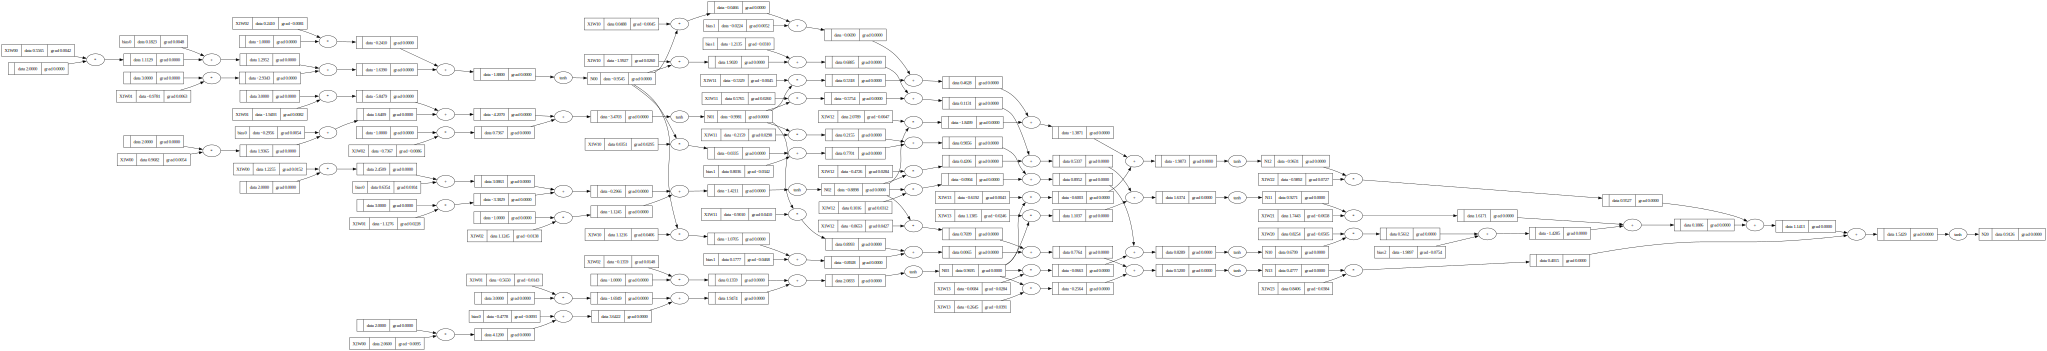

In [88]:
dot = graph.Digraph("nn1",graph_attr={'rankdir': 'LR'},node_attr={"orientation":"270"})
draw_nn(nn(xs[0]),dot)